# 2. Data Balance by Label Substitution
---

In this notebook, we will look at the hashtags labels for each image, and fix the imbalance.

## Import Libraries (the following cells are copied from notebook 1)

In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.utils import shuffle

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

import os,sys
sys.path.append("../src")

## Create the Target Matrix
Form ```tag_list.txt``` and ```data_list.txt``` in HARRISON dataset, we create a target matrix as a DataFrame.

In [2]:
DATA_LIST = "../HARRISON/data_list.txt"
TAG_LIST = "../HARRISON/tag_list.txt"

#read filenames
filenames_df = pd.read_csv(DATA_LIST, names=["filename"], header=None) #read the files
filenames_df["filename"] = filenames_df["filename"].apply(lambda x: "_".join(x.split("/")[1:])) #drop dir names
filenames_series = filenames_df.iloc[:,0]

# Read hashtags
vectorizer = CountVectorizer(binary=True)
hashtags_df = pd.read_csv(TAG_LIST, names=["labels"], header=None)
X_arr = vectorizer.fit_transform(hashtags_df["labels"]).toarray()
X_df = pd.DataFrame(X_arr, index=filenames_series.to_numpy(), columns=vectorizer.get_feature_names())

#print
print(X_df)

                       ab  accessory  actor  actress  adidas  adorable  \
sea_image_50.jpg        0          0      0        0       0         0   
sea_image_1284.jpg      0          0      0        0       0         0   
sea_image_1122.jpg      0          0      0        0       0         0   
sea_image_1679.jpg      0          0      0        0       0         0   
sea_image_1736.jpg      0          0      0        0       0         0   
...                    ..        ...    ...      ...     ...       ...   
tattoo_image_796.jpg    0          0      0        0       0         0   
tattoo_image_1309.jpg   0          0      0        0       0         0   
tattoo_image_1276.jpg   0          0      0        0       0         0   
tattoo_image_347.jpg    0          0      0        0       0         0   
tattoo_image_1153.jpg   0          0      0        0       0         0   

                       adventure  aesthetic  afternoon  air  ...  yellow  \
sea_image_50.jpg               0   

## Visualize the data imbalance

In [3]:
from data_balance import Data_Balance,Word_Similarity

db = Data_Balance()
db.visualize_pdf(X_df)

<Figure size 640x480 with 1 Axes>

Variance in Frequency: 6.271672470561842e-05
5 Most Common Labels: [('love', 0.10267849363051774), ('friend', 0.06353798163219072), ('beach', 0.052715961173169755), ('family', 0.051687782095742645), ('yellow', 0.046477179652510324)]
5 Least Common Labels: [('daytime', 3.48535280483767e-05), ('hters', 6.97070560967534e-05), ('wakingup', 6.97070560967534e-05), ('shamelessselefie', 8.713382012094175e-05), ('textgram', 8.713382012094175e-05)]


## Balance the data

In [4]:
#copy our old dataframe so we can preserve it
Balanced_X_df = X_df.copy(deep=True)
#store dimensions
num_images,num_labels = Balanced_X_df.shape

In [5]:
#we'd like for the model to certainly predict the image type
#ex: the model should always predict 'snow' in a snow_image_X.jpg picture

#we don't want a beach_image_X.jpg picture to be labeled as 'amazing' because amazing_image_X.jpg's exist
col_of_zeros = np.zeros((num_images,1))

#get image types
image_types = set()
for filename in Balanced_X_df.index:
    image_types.add(filename.split('_')[0])

#zero these columns
#side effect: some image types like 'friends' are not tags in the data...This adds them!
added_image_types = []
for image_type in image_types:
    if image_type not in Balanced_X_df.columns:
        added_image_types.append(image_type)
    Balanced_X_df[image_type] = col_of_zeros

#add the appropiate tags back
for filename in Balanced_X_df.index:
    tag = filename.split('_')[0]
    if Balanced_X_df.loc[filename,tag] == 0:
        Balanced_X_df.loc[filename,tag] = 1
        
#update dimensions
num_images,num_labels = Balanced_X_df.shape

In [6]:
print(image_types)

{'heart', 'drunk', 'snow', 'loveyou', 'smile', 'tree', 'goodtimes', 'boy', 'black', 'bored', 'throwback', 'green', 'beauty', 'school', 'friday', 'cool', 'amazing', 'awesome', 'eyes', 'home', 'family', 'red', 'yellow', 'girls', 'instafood', 'hair', 'beach', 'dog', 'justinbieber', 'yum', 'fashion', 'nike', 'yummy', 'cake', 'sun', 'friends', 'model', 'truth', 'old', 'makeup', 'funny', 'igdaily', 'tired', 'sea', 'boyfriend', 'shoes', 'new', 'colorful', 'white', 'tattoo'}


In [7]:
#if a and b are very close in meaning/context, we expect to see both
synonym_clusters = [
        {'ab','bodybuilding','cardio','exercise','fit','fitfam','fitgirl','fitness',
         'fitnessaddict','fitnessmodel','fitnessmotivation','fitspo','gain','gainpost',
         'gaintrick','gym','gymlife','instafit','squat','strong','weightloss','workout','muscle'},
        {'food','foodblogger','foodgasm','foodie','foodlover','foodphotography',
         'foodpic','foodporn','foodpics','foodporn','foodstagram','instafood','tasty','nomnom',
         'restaurant','yum','yummy'},
        {'healthy','healthychoices','healthyeating','healthyfood','vegan','vegetarian',
         'organic','salad','nutrition','cleaneating','eatclean'},
        #{'adorable','amor','cute','cutie'},
        #{'latepost','latergram'},
        {'shoe','shoes','nike','justdoit','airmax','nikeairmax','sneaker','sneakerhead','adidas'},
        {'bestfriend','bestfriends','besties','bff','friend','friends','friendship','goodfriends'},
        {'bieber','belieber','beliebers','justinbieber','justin'},
        {'birthday','birthdaycake','cake','cupcake','instacake','happybirthday','bday'},
        #{'brazil','brasil'},
        {'dog','doglover','dogoftheday','dogsofinstagram','dogstagram','ilovemydog',
         'instadog','puppy'},
        {'cat','catsofinstagram','kitty'},
        #{'dance','dancer'},
        {'sky','skylovers','skyporn','bluesky','cloud','cloudporn'},
        {'instanature','mothernature','nature','naturelovers','naturephotography','outdoor',
         'mountain','outdoors','tree','forest'},
        #{'iphone','iphoneonly','iphonesia','apple'},
        {'lol','lmao','lmfao','kik','laugh','haha','funny'},
        {'drink','alcohol','cocktail','beer','drunk'},
        {'basketball','lakers','kobe','kobebryant','mambaday','nba'},
        #{'omg','wtf'},
        #{'spring','springtime','primavera','april'},
        {'relationship','relationshipgoals','boyfriend','girlfriend','bae','babe'},
        {'ski','skiing','snow','snowboard','snowboarding','ice','cold','winter'},
        {'university','school','student','teacher','college'},
        {'instamakeup','makeup','makeupaddict','makeupartist','makeupjunkie','makeuplover',
         'nomakeup','mac','maccosmetics','lipstick','nailart','eyeliner','eyeshadow','cosmetic','anastasiabeverlyhills'},
        {'flower','flowerstagram','tulip','rose'},
        #{'follow','followalways','followback','follower','followforfollow','following','followme',
        # 'followtrain','instafollow','likeforfollow','like','likeforlike','likeforlikes','likeback',
        # 'instalike','instalikes','likeit','likeme','tagforlikes','tagsforlike','tagsforlikes',
        # 'tagsforlikesapp','hashtag','hashtags','instagram','instagramers','instagramhub','tag',
        # 'tagsta','toptags','lfl','fff'},
        {'throwback','throwbackthursday','tbt'},
        {'sweettooth','dessert','dessertporn','chocolate'},
        {'delish','delicious'},
        {'art','arte','artist','artistic','artwork','instaart'},
        {'beach','beachlife','sea','seaside','ocean','sand','playa'},
        {'coffee','goodmorning','morning','instamorning','wake','wakeup','awake','early','earlybird','wakingup'},
        {'travel','traveller','instatravel','travelgram','traveling','travelingram','travelling',
         'travelphotography','trip','roadtrip','vacation','explore'},
        {'trend','trendy'},
        #{'sun','sunglass','sunlight','sunny','sunnyday','sunshine'},
        #{'surf','surfing'},
        #{'summer','summertime'},
        #{'run','running'},
        #{'photography','photograph','photographer','photogrid','photooftheday','pic','picoftheday',
        #'picture','pictureoftheday'},
        {'girls','girl','girly','instagirl'},
        {'model','modeling'},
        {'goodtime','goodtimes','goodvibes','positivevibes','funtimes','goodlife','lifeisgood','goodlife'},
        {'fashion','fashionable','fashionaddict','fashionblog','fashionblogger','fashiondiaries',
         'fashiongram','fashionista','fashionstyle','instafashion','streetfashion','outfit',
         'outfitoftheday','dress'},
        #{'film','movie'},
        {'tattoo','tattooed','girlswithtattoos'},
        #{'sleep','sleepy','tired'},
        #{'decor','decoration'},
        #{'clothes','clothing'},
        {'eye','eyes','blueeyes','greeneye'},
        {'yellow'},
        {'loveyou'},
        {'family'}
    ]
    
#check that tags are spelled correctly (can be found in dataframe column labels)
for cluster in synonym_clusters:
    for c in cluster:
        if c not in Balanced_X_df.columns:
            print (c,'not found')
            
#check that tags do not belong to multiple clusters
for i in range(len(synonym_clusters)):
    clust_i = synonym_clusters[i]
    for label_i in clust_i:
        for clust_j in synonym_clusters[i+1:]:
            if label_i in clust_j:
                print(label_i,'in',clust_i,'and',clust_j)

In [8]:
#turn the cluster list into a substitution dataframe
#Substitutions_df[i,j] iff label i is in the same cluster as label j -> let's us substitute with dot product!
zeros_arr = np.zeros((num_labels,num_labels))
Substitutions_df = pd.DataFrame(data=zeros_arr,index=Balanced_X_df.columns, columns=Balanced_X_df.columns)
for cluster in synonym_clusters:
    cluster_list = list(cluster)
    for i in range(len(cluster_list)):
        label_i = cluster_list[i]
        for label_j in cluster_list[i:]:
            Substitutions_df.loc[label_i,label_j] = Substitutions_df.loc[label_j,label_i] = 1

In [9]:
#obtain the dataframe where each instance is a set of label clusters
clustered_df = Balanced_X_df.dot(Substitutions_df).astype('int64')

#keep some non-clustered uncommon tags as noise
noisey_df = ((Balanced_X_df - clustered_df) > 0).astype('int64')

#remove the very common noise
max_freq = noisey_df.sum(axis=0).max()
frequency_threshold = 0.1
noisey_labels_series = (noisey_df.sum(axis=0) > (frequency_threshold*max_freq)).astype('int64')
noisey_labels_list = noisey_labels_series[noisey_labels_series==1].index
print('Removing noisey unclustered Labels:',noisey_labels_list)
for label in noisey_labels_list:
    noisey_df[label] = col_of_zeros

#add filtered noise back to clustered dataframe
Balanced_X_df = (clustered_df + noisey_df).astype('int64')

Removing noisey unclustered Labels: Index(['awesome', 'beautiful', 'black', 'blackandwhite', 'blue', 'bored',
       'boy', 'cool', 'cute', 'follow', 'followme', 'friday', 'fun', 'green',
       'hair', 'happy', 'heart', 'holiday', 'home', 'instadaily', 'instagood',
       'instagram', 'instalike', 'instamood', 'instapic', 'life', 'like',
       'likeforlike', 'love', 'music', 'new', 'night', 'old', 'ootd', 'party',
       'photo', 'photography', 'photooftheday', 'picoftheday', 'pink', 'red',
       'selfie', 'smile', 'spring', 'style', 'summer', 'sun', 'sunday',
       'sunset', 'tired', 'truth', 'vsco', 'vscocam', 'weekend'],
      dtype='object')


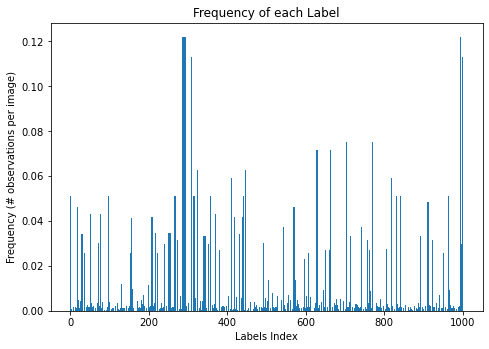

Variance in Frequency: 0.0006296687582979968
5 Most Common Labels: [('food', 0.12214418904553613), ('foodblogger', 0.12214418904553613), ('foodgasm', 0.12214418904553613), ('foodie', 0.12214418904553613), ('foodlover', 0.12214418904553613)]
5 Least Common Labels: [('awesome', 0.0), ('beautiful', 0.0), ('black', 0.0), ('blackandwhite', 0.0), ('blue', 0.0)]


In [10]:
db.visualize_pdf(Balanced_X_df)

The variance in the data is now actually higher, but now we've clustered related tags into several modes (rather than one). This way, the network will be biased to learn fewer, but more distinct clusters of tags. We will treat tags of frequency less than threshold L as noise (our network will not be able to "learn" these infrequent tags anyways), and oversample instances with tags of frequency>L.

In [11]:
#labels with frequency < L are noise
L = 0.18

#throw out instances with greater than T noisey labels
T=1000

In [12]:
#we want to avoid duplicating instances with tags:frequency < L and instances with tags:frequency=max
max_freq = Balanced_X_df.sum().max()
threshold_freq = L * max_freq

#labels that are not noise
labels_to_keep_series = (Balanced_X_df.sum(axis=0) > threshold_freq).astype('int64')
labels_to_keep_list = labels_to_keep_series.loc[labels_to_keep_series==1].index

#throw out instances with mostly noise
labels_to_avoid_series = (labels_to_keep_series == 0).astype('int64')
avoid_df = Balanced_X_df.dot(labels_to_avoid_series)
indicies_to_drop = avoid_df.loc[avoid_df>T].index
Balanced_X_df = Balanced_X_df.drop(indicies_to_drop,axis='index')
print("Dropped",indicies_to_drop.shape[0],"noisey instances!")

#computationally cheaper to reduce candidates for duplication at every iteration
duplicatable_Balanced_X_df = Balanced_X_df.copy(deep=True)

#number of duplications per iteration
k = 10
num_images_duplicated = 0
while (1): 

    #check the current frequency of the labels
    counts = Balanced_X_df.sum(axis=0)
    labels_to_avoid = (counts < threshold_freq).astype('int64') | (counts >= max_freq).astype('int64')
        
    #the dot product of Balanced_X_df and labels_to_avoid will result in a series, where 0 indicates that row can be duped
    duplication_df = duplicatable_Balanced_X_df.dot(labels_to_avoid)
    
    #choose k of the indicies
    duplicatable_indicies = duplication_df.loc[duplication_df==0].index
    num_choices = min(k,duplicatable_indicies.shape[0])
    if(num_choices == 0):
        print('No more images to duplicate!')
        break
    else:
        print('Duplicating '+str(num_choices)+'/'+str(duplicatable_indicies.shape[0])+' images...')
        
    #keep only duplicatable images
    duplicatable_Balanced_X_df = duplicatable_Balanced_X_df.loc[duplicatable_indicies,:]
            
    #duplicate the indicies_to_duplicate of the dataframe
    indicies_to_duplicate = np.random.choice(duplicatable_indicies,num_choices,replace=False)
    dataframe_to_append = Balanced_X_df.loc[indicies_to_duplicate , :]
    Balanced_X_df = Balanced_X_df.append(dataframe_to_append)
    
    #update the number of images duplicated
    num_images_duplicated += num_choices
print('Duplicated '+str(num_images_duplicated)+' images!')

Dropped 0 noisey instances!
Duplicating 10/14751 images...
Duplicating 10/14751 images...
Duplicating 10/14751 images...
Duplicating 10/14751 images...
Duplicating 10/14751 images...
Duplicating 10/14751 images...
Duplicating 10/14751 images...
Duplicating 10/14751 images...
Duplicating 10/14751 images...
Duplicating 10/14751 images...
Duplicating 10/14751 images...
Duplicating 10/14751 images...
Duplicating 10/14751 images...
Duplicating 10/14751 images...
Duplicating 10/14751 images...
Duplicating 10/14751 images...
Duplicating 10/14751 images...
Duplicating 10/14751 images...
Duplicating 10/14751 images...
Duplicating 10/14751 images...
Duplicating 10/14751 images...
Duplicating 10/14751 images...
Duplicating 10/14751 images...
Duplicating 10/14751 images...
Duplicating 10/14751 images...
Duplicating 10/14751 images...
Duplicating 10/14751 images...
Duplicating 10/14751 images...
Duplicating 10/14751 images...
Duplicating 10/14751 images...
Duplicating 10/14751 images...
Duplicating

KeyboardInterrupt: 

## Visualize the balanced data

In [ ]:
db.visualize_pdf(Balanced_X_df.loc[:,labels_to_keep_list])

## Save to .csv

In [ ]:
import os

#save balanced tag lists to files
tag_list_pathname = os.path.join("..","HARRISON","2.4_3_balanced_tag_list.txt")
data_list_pathname = os.path.join("..","HARRISON","2.4_3_balanced_data_list.txt")

tag_list_similarity_balanced_series = Balanced_X_df.dot((Balanced_X_df.columns.to_numpy() + " "))
data_list_similarity_balanced_series = pd.Series(Balanced_X_df.index)

tag_list_similarity_balanced_series.to_csv(tag_list_pathname,header=False,index=False)
data_list_similarity_balanced_series.to_csv(data_list_pathname,header=False,index=False)